In [1]:
import numpyro
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
from matplotlib import pyplot as plt
import pandas as pd
from jax import random

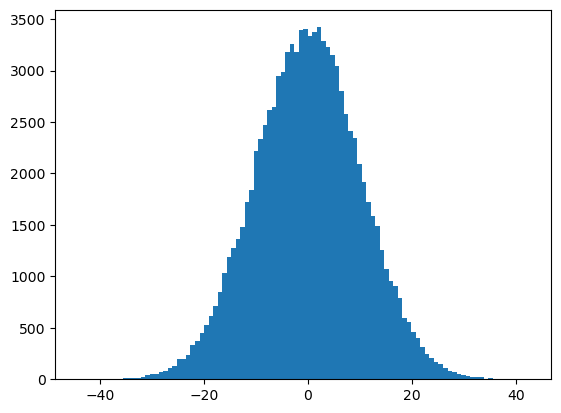

In [2]:
def model(y=None):
    mu = numpyro.sample("mu", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


n_samples = 100000
samples = numpyro.infer.Predictive(model, num_samples=n_samples)(random.PRNGKey(0))
plt.hist(samples["y"], bins=100)
plt.show()

In [3]:
data_raw = pd.read_csv("../data/Howell1.csv", sep=";")

data = data_raw[data_raw.age >= 18]

100%|██████████| 2000/2000 [00:00<00:00, 9197.76it/s, init loss: 40615.7656, avg. loss [1901-2000]: 1078.5883]


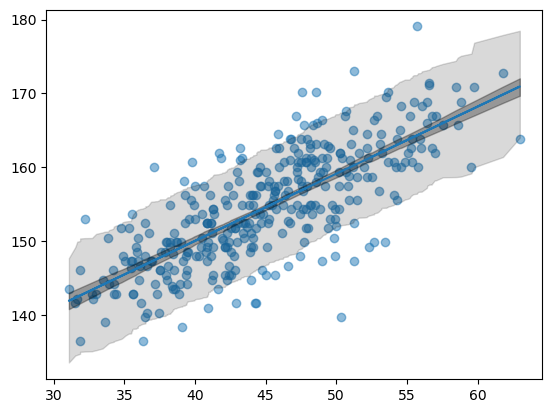

In [6]:
avg_weight = data.weight.mean()

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(138, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - avg_weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), weight=data.weight.values, height=data.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
svi_result.params

samples = guide.sample_posterior(random.PRNGKey(1), svi_result.params, (100,))
mu_hdpi = hpdi(samples["mu"], 0.89, axis=0)
mu_mean = samples["mu"].mean(axis=0)

sims = Predictive(model, samples)(random.PRNGKey(2), data.weight.values, None)
height_hdpi = hpdi(sims["height"], 0.89, axis=0)

plt.scatter(data.weight, data.height, alpha=0.5)
plt.plot(data.weight, mu_mean)

plt.fill_between(sorted(data.weight), sorted(mu_hdpi[0]), sorted(mu_hdpi[1]), alpha=0.3, color="k")
plt.fill_between(sorted(data.weight), sorted(height_hdpi[0]), sorted(height_hdpi[1]), alpha=0.15, color="k")
plt.show()

In [35]:
weight_bar = data.weight.mean()

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - weight_bar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m,
    optim.Adam(1),
    Trace_ELBO(),
    weight=data.weight.values,
    height=data.height.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
post = m.sample_posterior(random.PRNGKey(0), svi_result.params, (10000,))

weights = jnp.array([46.95, 43.72, 64.78, 32.59, 54.63])

sim = Predictive(m.model, post)(random.PRNGKey(2), weights, None)

height_mean = sim["mu"].mean(axis=0)

height_hdpi = hpdi(sim["height"], 0.89, axis=0)

print(height_mean)
print(height_hdpi)

100%|██████████| 2000/2000 [00:00<00:00, 7993.03it/s, init loss: 40631.5430, avg. loss [1901-2000]: 1078.9297]


[156.37799 153.4511  172.5348  143.36554 163.33731]
[[148.0967  145.40984 164.78192 134.985   155.25443]
 [164.58464 161.4594  181.04309 151.17339 171.68039]]


In [32]:
print(sim["mu"].min(axis=0))
print(sim["mu"].max(axis=0))

[155.33017 152.50044 169.35449 140.64148 161.43408]
[157.50285 154.5766  175.89093 145.52475 165.20746]


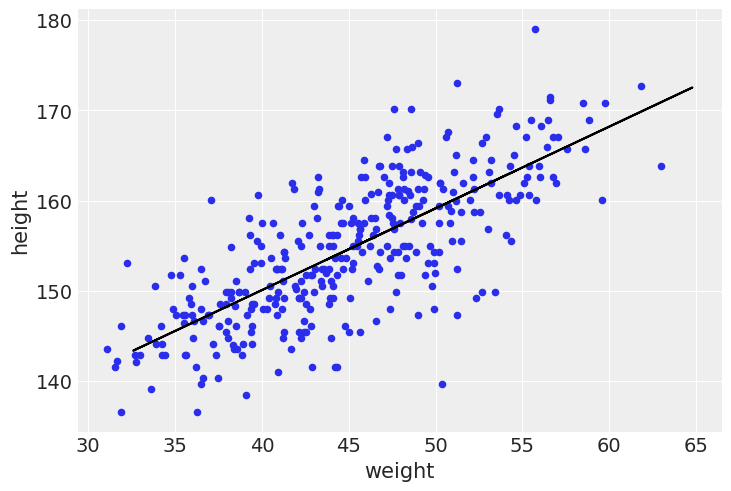

In [18]:
data.plot("weight", "height", kind="scatter")
plt.plot(weights, height_mean, "k")